In [1]:
cfg={
    'main_folder':'/Users/matejkvassay/data/sketch-testing/',
    'save_allowed':True,
    'dataset_file':'dataset.npy',
    'dev_mode': True,
    'dev_mode_dataset_count_limit': 1000,
    'dist_estimation_ref_obj_count': 100,
    'dist_estimation_p_vals':[1,2],
    'evaluation_set_query_obj_cnt':100,
    'evaluation_set_result_set_size':100,
    'ghp_pivot_couple_candidates': 50,
    'min_balancing_score': 0.1,
    'after_partitiong_checkpoint_file': 'after_partitioning.checkpoint'
}

In [2]:
%matplotlib inline
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from scipy.spatial.distance import minkowski, hamming
from fractions import Fraction 
from time import time
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import pylab
import scipy as sp
import cPickle

In [3]:
logger = logging.getLogger()
logger.setLevel('INFO')
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(ch)

In [4]:
def log_pfx(obj, msg, *args):
    logger.info(obj.__class__.__name__+'| '+msg, *args)
    
def save_to(obj, file_path):
    with open(file_path, 'wb') as f:
        cPickle.dump(obj,f)

def load_from(file_path):
    with open(file_path, 'rb') as f:
        return cPickle.load(f)

def show_text(title,xlabel,ylabel):
    plt.suptitle(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
def heatmap(x,y,bins=50,figsize=(5,5),title=None, xlabel=None, ylabel=None):
    plt.figure(figsize=figsize)
    heatmap, xedges, yedges = np.histogram2d(x, y, bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    plt.clf()
    plt.imshow(heatmap.T, extent=extent, origin='lower')
    show_text(title,xlabel,ylabel)
    plt.show()
    
def scatter(x,y,title=None, xlabel=None, ylabel=None, point_size=5):
    plt.scatter(x, y, s=[point_size for _ in range(len(x))])
    plt.suptitle(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def scatter_array(arr, title=None, xlabel=None, ylabel=None, point_size=5):
    ser=pd.Series(arr)
    plt.scatter(ser.index, ser, s=[point_size for _ in range(len(arr))])
    plt.suptitle(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def plot_array(arr, title=None, xlabel=None, ylabel=None):
    pd.Series(arr).plot(grid=True)
    plt.suptitle(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def hist_array(arr,bins=50, title=None, xlabel=None, ylabel=None):
    pd.Series(arr).hist(bins=bins,grid=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.suptitle(title)
    plt.show()
    
def restrict_2d_space(x,y,x_interval, y_interval):
    conditions=[x>=x_interval[0], x<=x_interval[1], y>=y_interval[0], y<=y_interval[1]]
    mask=conditions[0]
    for condition in conditions[1:]:
        mask=np.logical_and(mask,condition)
    return x[mask], y[mask]
    
class IterationLogger(object):
    def __init__(self, message='Started iteration no.: %s\n Time from previous iteration: %ss\n Time from start: %ss',log_by=1000):
        self.log_by=log_by
        self.num_iter=0
        self.msg=message
        self.time_started=None
        self.time_this_iter=None
        
    def next_iter(self):
        if self.time_this_iter is None:
            self.time_this_iter=time()
        if self.time_started is None:
            self.time_started=time()
        self.num_iter+=1
        if self.num_iter%self.log_by==0:
            dur_from_previous=time()-self.time_this_iter
            self.time_this_iter=time()
            dur_from_start=time()-self.time_started
            log_pfx(self, self.msg, str(self.num_iter), str(dur_from_previous), str(dur_from_start))
            

### LOAD DATA

In [5]:
dataset_path=cfg['main_folder']+cfg['dataset_file']

In [6]:
with open(dataset_path, 'rb') as f:
    decaf_vecs=np.load(f)
if cfg['dev_mode']:
    decaf_vecs=decaf_vecs[:cfg['dev_mode_dataset_count_limit']]
obj_ids=np.arange(len(decaf_vecs))

In [7]:
decaf_vecs.shape #(vectors count, vector length)

(1000, 4096)

### DATA ANALYSIS


#### Distance distribution estimation

In [8]:
def estimate_minkowski_dist_distr(vec_matrix, ref_obj_cnt, p):
    '''
    p can be either single value or list of p parameters for minkowski distance
    '''
    distances=[list() for _ in range(len(p))]
    reference_objs=vec_matrix[np.random.choice(vec_matrix.shape[0], size=ref_obj_cnt, replace=False)] #sampling without replacement
    iter_log=IterationLogger(log_by=5000)
    for decaf_vec in decaf_vecs:
        iter_log.next_iter()
        for ref_obj in reference_objs:
            for i, val_p in enumerate(p):
                dist=minkowski(ref_obj, decaf_vec, p=val_p)
                distances[i].append(dist)
    return tuple(distances)


In [9]:
dist_l1, dist_l2 = estimate_minkowski_dist_distr(decaf_vecs,  cfg['dist_estimation_ref_obj_count'], cfg['dist_estimation_p_vals'])

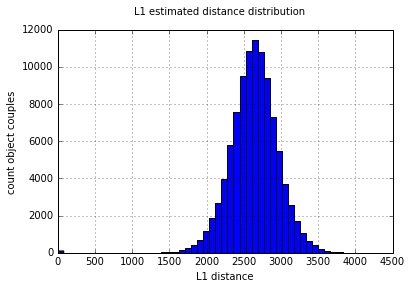

In [10]:
hist_array(dist_l1, bins=50, title='L1 estimated distance distribution',ylabel='count object couples', xlabel='L1 distance')

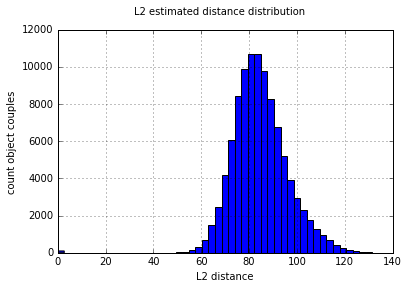

In [11]:
hist_array(dist_l2, bins=50,title='L2 estimated distance distribution',ylabel='count object couples', xlabel='L2 distance')

## APPROXIMATION  EVALUATION SET
We select 100 query objects and their 100 closest object's id's from the dataset to evaluate. It simulates the scenario where almost never more than 100 objects are required for result set. 

In [12]:
eval_queries_indicies=np.random.choice(decaf_vecs.shape[0], size=cfg['evaluation_set_query_obj_cnt'], replace=False)
eval_queries_vecs=decaf_vecs[eval_queries_indicies] 
eval_queries_ids=obj_ids[eval_queries_indicies]
eval_k=cfg['evaluation_set_result_set_size'] #k for knn to evaluation objects

In [13]:
eval_result_objs=[list() for _ in range(len(eval_queries_ids))]

Finds k-NN query result

In [14]:
iter_log=IterationLogger(log_by=5000)
for i in range(len(decaf_vecs)):
    iter_log.next_iter()
    candidate_vec=decaf_vecs[i]
    candidate_id=obj_ids[i]
    for j in range(len(eval_queries_vecs)):
        query_vec=eval_queries_vecs[j]
        dist=minkowski(candidate_vec, query_vec, p=1)
        if len(eval_result_objs[j])>0:
            if dist<eval_result_objs[j][-1][1]: #if object is not member of result set
                eval_result_objs[j].append((candidate_id, dist))
                eval_result_objs[j].sort(key=lambda x: x[1],reverse=False)
                if len(eval_result_objs[j])>eval_k:#if > k objects remove last one
                    del eval_result_objs[j][-1] 
        else:
            eval_result_objs[j].append((candidate_id, dist))
            

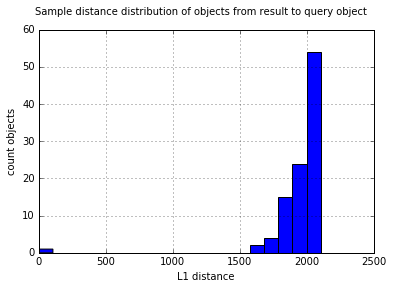

In [15]:
hist_array([obj[1] for obj in eval_result_objs[17]],bins=20,title='Sample distance distribution of objects from result to query object',xlabel='L1 distance',ylabel='count objects')

## GENERALIZED HYPERPLANE PARTITIONING PIVOTS SELECTION

In [16]:
pivot_cand_cpl_cnt=cfg['ghp_pivot_couple_candidates']

Select random pivot couples

In [17]:
cand_indicies=np.random.choice(decaf_vecs.shape[0], size=pivot_cand_cpl_cnt*2, replace=False)
pivot_cand_vecs=decaf_vecs[cand_indicies]
pivot_cand_ids=obj_ids[cand_indicies]
pivot_cand_vecs_a, pivot_cand_vecs_b=np.split(pivot_cand_vecs,2)
pivot_cand_ids_a, pivot_cand_ids_b=np.split(pivot_cand_ids,2)
pivot_cand_vecs=np.array(zip(pivot_cand_vecs_a, pivot_cand_vecs_b))
pivot_cand_ids=np.array(zip(pivot_cand_ids_a, pivot_cand_ids_b))

In [18]:
def get_ghp_partition(obj, pivot_a, pivot_b, p=1):
    '''
    returns partition 0/1 and distance to closest pivot
    '''
    dist_a=minkowski(vec, pivot_cpl_vec[0], p=p)
    dist_b=minkowski(vec, pivot_cpl_vec[1], p=p)
    if dist_a<dist_b:
        return 1, dist_a
    if dist_a>dist_b:
        return 0, dist_b
    return np.random.choice([0,1]), dist_a
    
def compute_part_balance(cnt_partition, cnt_all):
    '''
    1 - 2*|0.5-x/y| where x is count members in left or right partition and y is count all members
    '''
    return 1.0-(2*abs(0.5-(cnt_partition/cnt_all)))

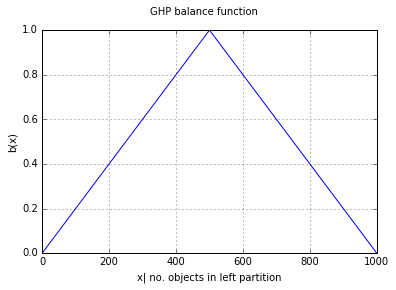

In [19]:
#plot balance function
plot_array([compute_part_balance(float(num),float(1000)) for num in range(0,1001)], title='GHP balance function',xlabel='x| no. objects in left partition',ylabel='b(x)')



Partition all objects from database and collect useful statistics for pivot couple selection

In [20]:
partitions=np.zeros(shape=(decaf_vecs.shape[0], len(pivot_cand_ids)), dtype=np.float32)
left_members_cnt=np.zeros(len(pivot_cand_ids), dtype=np.float32)
sum_dist_from_ghp=np.zeros(len(pivot_cand_ids), dtype=np.float32)

In [21]:
iter_log=IterationLogger(log_by=1000)
for i, vec in enumerate(decaf_vecs):
    iter_log.next_iter()
    for j, pivot_cpl_vec in enumerate(pivot_cand_vecs):
        partition,dist=get_ghp_partition(vec, pivot_cpl_vec[0], pivot_cpl_vec[1], p=1)
        partitions[i][j]=partition
        left_members_cnt[j]+=partition
        sum_dist_from_ghp[j]+=dist

2017-04-29 15:36:02,544 - root - INFO - IterationLogger| Started iteration no.: 1000
 Time from previous iteration: 2.97125506401s
 Time from start: 2.97125506401s


Checkpoint

In [22]:
#Partitioning balance score
balance_scores=np.array([compute_part_balance(float(cnt), float(decaf_vecs.shape[0])) for cnt in left_members_cnt])

In [23]:
'''
Partitioning with low balancing score is useless for filtering thus we'll remove such pivot couples right away. 
'''
balance_limit=float(cfg['min_balancing_score'])
bal_mask=np.array([i for i, score in enumerate(balance_scores) if score>=balance_limit])
balance_scores=balance_scores[bal_mask]
pivot_cand_vecs=pivot_cand_vecs[bal_mask]
partitions=np.array(partitions)[bal_mask]
left_members_cnt=np.array(left_members_cnt)[bal_mask]
sum_dist_from_ghp=np.array(sum_dist_from_ghp)[bal_mask]

In [24]:
'''
Compute distance from dividing hyperplane score.
Scale all distances to 0-1, 1 being the largest.
HP distance score: (d_i - min(D))/(max(D)-min(D))
'''
avg_dist_from_hp=[float(num)/decaf_vecs.shape[0] for num in sum_dist_from_ghp]

In [25]:
#Assign mean pairwise correlation score
correlations = np.mean(np.abs(np.corrcoef(np.matrix(partitions)))) #matrix of correlations of columns of sketch matrix

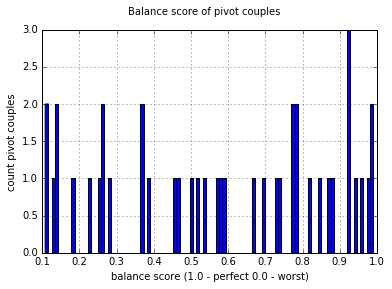

In [36]:
hist_array(balance_scores,bins=100, title='Balance score of pivot couples', xlabel='balance score (1.0 - perfect 0.0 - worst)', ylabel='count pivot couples')

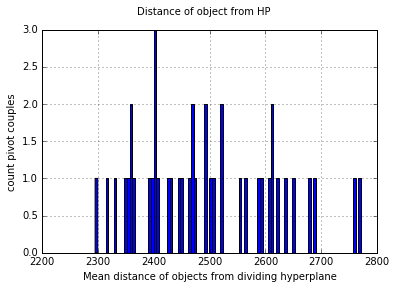

In [35]:
hist_array(avg_dist_from_hp, bins=100,xlabel='Mean distance of objects from dividing hyperplane', \
           ylabel='count pivot couples',title='Distance of object from HP')

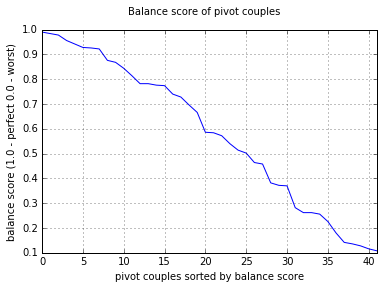

In [34]:
plot_array(sorted(balance_scores,reverse=True),title='Balance score of pivot couples', ylabel='balance score (1.0 - perfect 0.0 - worst)', xlabel='pivot couples sorted by balance score')

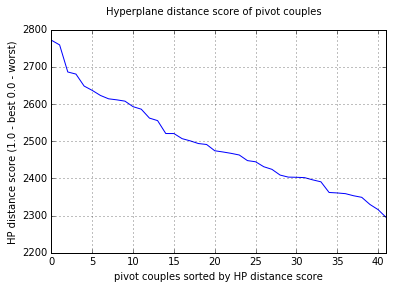

In [33]:
plot_array(sorted(avg_dist_from_hp,reverse=True),title='Hyperplane distance score of pivot couples', ylabel='HP distance score (1.0 - best 0.0 - worst)', xlabel='pivot couples sorted by HP distance score')

### Checkpoint

Save

In [30]:
if cfg['save_allowed']:
    save_to((decaf_vecs, eval_queries_vecs,eval_queries_ids, eval_k, pivot_cand_vecs,eval_result_objs,\
             pivot_cand_ids, partitions, balance_scores, avg_dist_from_hp, correlations),\
            cfg['main_folder']+cfg['after_partitiong_checkpoint_file'])

Load

In [32]:
decaf_vecs, eval_queries_vecs,\
eval_queries_ids, eval_k, \
pivot_cand_vecs,eval_result_objs,\
pivot_cand_ids, partitions, balance_scores,\
avg_dist_from_hp, correlations=load_from(cfg['main_folder']+cfg['after_partitiong_checkpoint_file'])